# Differential Expression with limma-voom pipeline - Genes

In [1]:
suppressMessages({library(SummarizedExperiment)
                  library(data.table)
                  library(limma)
                  library(edgeR)
                  library(dplyr)
                  library(sva)})

## Prepare Data

In [2]:
# Function from jaffelab github
merge_rse_metrics <- function(rse) {
    stopifnot(is(rse, 'RangedSummarizedExperiment'))
    stopifnot(
        c('concordMapRate', 'overallMapRate', 'mitoRate', 'rRNA_rate',
          'totalAssignedGene', 'numMapped', 'numReads', 'numUnmapped',
          'mitoMapped', 'totalMapped') %in%
            colnames(SummarizedExperiment::colData(rse))
    )

    stopifnot(all(sapply(c(
        'concordMapRate', 'overallMapRate', 'mitoRate', 'rRNA_rate',
        'totalAssignedGene', 'numMapped', 'numReads', 'numUnmapped',
        'mitoMapped', 'totalMapped'), function(var) {
            is(colData(rse)[, var], 'List')
        })
    ))

    rse$concordMapRate = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$concordMapRate, rse$numReads)
    rse$overallMapRate = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$overallMapRate, rse$numReads)
    rse$mitoRate = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$mitoRate, rse$numMapped)
    rse$rRNA_rate = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$rRNA_rate, rse$numMapped)
    rse$totalAssignedGene = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$totalAssignedGene, rse$numMapped)

    rse$numMapped = sapply(rse$numMapped, sum)
    rse$numReads = sapply(rse$numReads, sum)
    rse$numUnmapped = sapply(rse$numUnmapped, sum)
    rse$mitoMapped = sapply(rse$mitoMapped, sum)
    rse$totalMapped = sapply(rse$totalMapped, sum)
    return(rse)
}

### Load gene counts

In [3]:
load(paste0("/ceph/projects/v3_phase3_paper/inputs/phase3/_m/", 
            "count_data/caudate_brainseq_phase3_hg38_rseGene_merged_n464.rda"))
rse_gene

class: RangedSummarizedExperiment 
dim: 58037 464 
metadata(0):
assays(1): counts
rownames(58037): ENSG00000223972.5 ENSG00000227232.5 ...
  ENSG00000210195.2 ENSG00000210196.2
rowData names(10): Length gencodeID ... NumTx gencodeTx
colnames(464): R12864 R12865 ... R13503 R13504
colData names(71): BrNum RNum ... RNum.1 FlowCell

### Load genotype data

In [4]:
mds_file = paste0("/ceph/projects/v3_phase3_paper/inputs/genotypes/to_brnum/", 
                  "merge/to_plink/mds/_m/merged.mds")
mds = fread(mds_file) %>% 
    rename("snpPC1"="C1", "snpPC2"="C2", "snpPC3"="C3", 
           "snpPC4"="C4", "snpPC5"="C5") %>%
    mutate_if(is.character, as.factor)
mds[1:2, 1:5]

FID,IID,SOL,snpPC1,snpPC2
<fct>,<fct>,<int>,<dbl>,<dbl>
Br1303,Br1303,0,-0.0595023,0.000751113
Br1320,Br1320,0,-0.0764475,0.002862080


### Subset and recode

In [5]:
keepIndex = which((rse_gene$Dx %in% c("Control", "Schizo")) &  
                  rse_gene$Age > 17 & 
                  rse_gene$Race %in% c("AA", "CAUC"))
rse_gene = rse_gene[, keepIndex]
rse_gene$Dx = factor(rse_gene$Dx, levels = c("Control", "Schizo"))
rse_gene$Sex <- factor(rse_gene$Sex)
rse_gene

class: RangedSummarizedExperiment 
dim: 58037 394 
metadata(0):
assays(1): counts
rownames(58037): ENSG00000223972.5 ENSG00000227232.5 ...
  ENSG00000210195.2 ENSG00000210196.2
rowData names(10): Length gencodeID ... NumTx gencodeTx
colnames(394): R12864 R12865 ... R13503 R13504
colData names(71): BrNum RNum ... RNum.1 FlowCell

In [6]:
rse_gene <- merge_rse_metrics(rse_gene)

rse_gene$ERCCsumLogErr <- mapply(function(r, n) {
        sum(r * n)/sum(n)
    }, rse_gene$ERCCsumLogErr, rse_gene$numReads)
colData(rse_gene)$RIN = sapply(colData(rse_gene)$RIN,"[",1)

pheno = colData(rse_gene) %>% as.data.frame %>% 
    inner_join(mds, by=c("BrNum"="FID"))
table(pheno$Sex)


  F   M 
121 273 

### Generate DGEList

In [7]:
x <- DGEList(counts=assays(rse_gene)$counts, 
             genes=rowData(rse_gene), samples=pheno)

### Filtering low counts

In [8]:
design0 <- model.matrix(~Sex, data=x$samples)
keep.x <- filterByExpr(x, design=design0)
x <- x[keep.x, , keep.lib.sizes=FALSE]
print(paste('There are:', sum(keep.x), 'features left!', sep=' '))

[1] "There are: 23498 features left!"


### Normalize counts

In [9]:
x <- calcNormFactors(x, method="TMM")

## Differential Expression Analysis

### Design matrix

In [10]:
mod = model.matrix(~Sex + Dx + Age + mitoRate +
        rRNA_rate + totalAssignedGene + RIN +
        ERCCsumLogErr + overallMapRate +
        snpPC1 + snpPC2 + snpPC3,
        data = x$samples)

colnames(mod) <- gsub("Dx", "", colnames(mod))
colnames(mod) <- gsub("SexM", "Male", colnames(mod))
colnames(mod) <- gsub("\\(Intercept\\)", "Intercept",
                         colnames(mod))

head(mod, 2)

,Intercept,Male,Schizo,Age,mitoRate,rRNA_rate,totalAssignedGene,RIN,ERCCsumLogErr,overallMapRate,snpPC1,snpPC2,snpPC3
R12864,1,0,1,42.98,0.03265387,8.675159e-05,0.5148545,9.6,-59.97567,0.9093498,-0.0595023,0.000751113,-0.00681555
R12865,1,1,1,53.12,0.01978740,6.976684e-05,0.5207789,9.5,-45.71034,0.8734840,-0.0764475,0.002862080,-0.00427266


### Calculate SVAs

In [11]:
print(paste('Determining number of surragate variables ...', Sys.time(), sep=' '))
n.sv <- num.sv(x$counts, mod, method="be")
null.model = as.matrix(as.data.frame(mod)[, !(names(as.data.frame(mod)) %in% c("Male"))])

print(paste('Fitting SV model ...', Sys.time(), sep=' '))
svobj <- svaseq(x$counts, mod, null.model, n.sv=n.sv)

[1] "Determining number of surragate variables ... 2020-10-30 19:43:34"
[1] "Fitting SV model ... 2020-10-30 19:50:59"
Number of significant surrogate variables is:  4 
Iteration (out of 5 ):1  2  3  4  5  

### Merge models

In [12]:
print(paste('Adding SV to design matrix ...', Sys.time(), sep=' '))
modQsva <- cbind(mod, svobj$sv)
len.d <- length(colnames(modQsva))
colnames(modQsva)[((len.d - n.sv)+1):len.d] <- make.names(paste0("sv",1:n.sv))

[1] "Adding SV to design matrix ... 2020-10-30 19:51:46"


### Preform voom

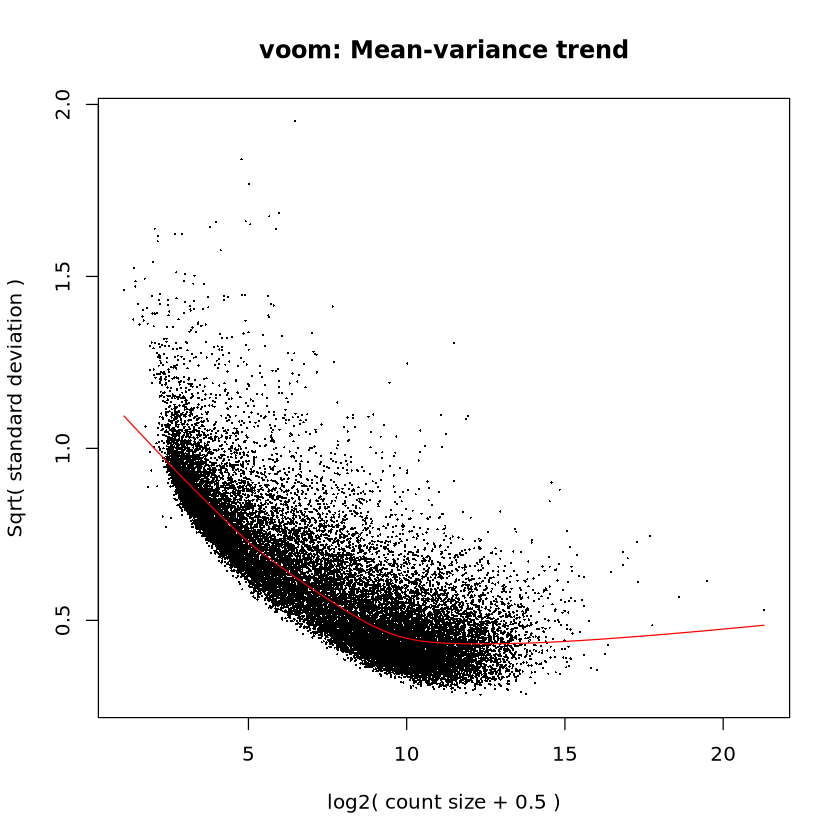

In [13]:
v <- voom(x, modQsva, plot=TRUE)

In [ ]:
feature = 'genes'
dir.create(feature)
save(v, file=paste0(feature,'/voomSVA.RData'))

### Calculate residuals

In [ ]:
null_model = v$design %>% as.data.frame %>% select(-c("Male")) %>% as.matrix
fit_res <- lmFit(v, design=null_model)
res = v$E - ( fit_res$coefficients %*% t(null_model) )
res_sd = apply(res, 1, sd)
res_mean = apply(res, 1, mean)

### Normalize residuals and write to file

In [ ]:
res_norm = (res - res_mean) / res_sd
write.table(res_norm, file=paste0(feature, '/residualized_expression.tsv'),
            sep="\t", quote=FALSE)

### Fit model with limma

In [ ]:
fit0 <- lmFit(v, modQsva)
contr.matrix <- makeContrasts(MvsF = Male, 
                              levels=colnames(modQsva))
fit <- contrasts.fit(fit0, contrasts=contr.matrix)

### Calculate differential expression with eBayes

In [ ]:
esv <- eBayes(fit)

options(width=200)
top0 <- topTable(esv, coef=1, number=Inf, sort.by="P")
sigTest <- decideTests(esv)

top <- merge(top0, sigTest, by=0)
rownames(top) <- top$Row.names
top <- top[,-1]
top <- top[order(top$P.Value), ]
top <- subset(top, select=-gencodeTx)
dim(top)

In [ ]:
write.table(top, file=paste0(feature, "/diffExpr_maleVfemale_full.txt"),
            sep='\t', row.names=TRUE, quote=FALSE)

### Subset via FDR

In [ ]:
top.fdr <- top[top$adj.P.Val<=0.05,]
print(paste('There are:', dim(top.fdr)[1], 'DE features!'))

In [ ]:
subset(top.fdr, Symbol == 'DISC1')

In [ ]:
write.table(top.fdr, file=paste0(feature, "/diffExpr_maleVfemale_FDR05.txt"),
            sep='\t', row.names=TRUE, quote=FALSE)

## Volcano and MA plots

In [ ]:
with(top, plot(logFC, -log10(P.Value), pch=20, cex=0.6))
with(subset(top, adj.P.Val<=0.05), points(logFC, -log10(P.Value),
                                          pch=20, col='red', cex=0.6))
with(subset(top, abs(logFC)>0.50), points(logFC, -log10(P.Value),
                                          pch=20, col='orange', cex=0.6))
with(subset(top, adj.P.Val<=0.05 & abs(logFC)>0.50),
     points(logFC, -log10(P.Value), pch=20, col='green', cex=0.6))

In [ ]:
pdf(file=paste0(feature, "/volcanoPlot.pdf"), 8, 6)
with(top, plot(logFC, -log10(P.Value), pch=20, cex=0.6))
with(subset(top, adj.P.Val<=0.05), points(logFC, -log10(P.Value),
                                          pch=20, col='red', cex=0.6))
with(subset(top, abs(logFC)>0.50), points(logFC, -log10(P.Value),
                                          pch=20, col='orange', cex=0.6))
with(subset(top, adj.P.Val<=0.05 & abs(logFC)>0.50),
     points(logFC, -log10(P.Value), pch=20, col='green', cex=0.6))
dev.off()

In [ ]:
with(top, plot(AveExpr, logFC, pch=20, cex=0.5))
with(subset(top, adj.P.Val<0.05),
     points(AveExpr, logFC, col="red", pch=20, cex=0.5))

In [ ]:
pdf(file=paste0(feature, "/MAplot.pdf"), 8, 6)
with(top, plot(AveExpr, logFC, pch=20, cex=0.5))
with(subset(top, adj.P.Val<0.05),
     points(AveExpr, logFC, col="red", pch=20, cex=0.5))
dev.off()

## Repreducibility Information

In [ ]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()